<div class="row">
  <div class="column">
<img align="left" width="200" height="42" src="https://assets.ensam.eu/logo/fr/logo-trans-322x84.png" />  </div>
  <div class="column">
<img align="right" width="120" height="42" src="https://upload.wikimedia.org/wikipedia/commons/b/bd/CC-BY-NC-SA.svg"/>  </div>
</div>

Jean-Christophe Loiseau  
Maître de Conférences  
&#128231; : jean-christophe.loiseau@ensam.eu  
&#128198; : Février 2020

In [1]:
# --> Import numpy (calcul scientifique de base).
import numpy as np

# --> Import matplotlib pour tracer les figures.
import matplotlib.pyplot as plt

# -->
from scipy.linalg import norm
from scipy.linalg import solve_triangular as _solve_triangular
solve_triangular = lambda A, b: _solve_triangular(A, b, check_finite=False, lower=True)

# -->
from tqdm import trange, tqdm

# Résolution de systèmes linéaires

Dans ce TP, nous nous intéresserons à résoudre des systèmes linéaires du type

$$
    \mathbf{Ax} = \mathbf{b}
$$

avec $\mathbf{A} \in \mathbb{R}^{n \times n}$ et $\mathbf{x}, \mathbf{b} \in \mathbb{R}^{n}$.
Bien que, d'un point de vue formel, la solution puisse s'écrire simplement

$$
    \mathbf{x} = \mathbf{A}^{-1} \mathbf{b},
$$

nous verrons que calculer explicitement l'inverse d'une matrice pour de grandes valeurs de $n$ est une tâche d'une grande complexité pouvant requérir jusqu'à $n^3$ opérations (soit $10^{12}$ opérations pour une matrice de taille $10^4 \times 10^4$).

Afin de parer à ces difficultés, un certain nombre d'algorithmes dits *itératifs*, permettant d'approximer au mieux $\mathbf{A}^{-1} \mathbf{b}$ sans pour autant avoir à calculer $\mathbf{A}^{-1}$, ont été proposés au cours des cinquante dernières années.
De par l'omniprésence de ces systèmes linéaires en calcul scientifique, le développement de tels algorithmes est encore aujourd'hui un sujet de recherche très actif.

Dans la suite de ce TP, vous aurez à implémenter vous-même les algorithmes suivants :
- la méthode de Jacobi,
- la méthode de Gauss-Seidel,
- la méthode SOR (Successive Over Relaxation),
- la méthode SSOR (Symmetric Successive Over Relaxation).

Chacune d'entres elles sera présentée en détail. Notez par ailleurs que ces algorithmes sont parmis ceux les plus enseignés et vous trouverez donc un nombre incroyable de ressources en ligne si besoin.
Nous porterons une attention particulière à comment ces différents algorithmes se comportent lorsque l'on augmente la taille de la matrice considérée.
Vous comparerez également les performances de vos implémentations aux solveurs disponibles dans la bibliothèque python `scipy` qui est dédiée au calcul scientifique.

---
---

**NOTE :** Parce que résoudre efficacement des systèmes linéaires de grande dimension est d'une importance capitale en calcul scientifique, ce TP est plus long que les autres.
Vous aurez donc deux semaines complètes (au lieu d'une) pour le faire.


---
---

## L'exemple de l'équation de la chaleur stationnaire

Afin d'illustrer l'importance de la résolution de systèmes linéaires en calcul scientifique, le problème de l'équation de la chaleur en régime stationnaire nous accompagnera tout au long de ce TP.
Pour des raisons de simplicité, nous nous limiterons au cas uni-dimensionel.
Dans ce contexte, l'équation est donnée par

$$
    \left\{
    \begin{aligned}
        -\frac{\mathrm{d}^2 T}{\mathrm{d}x^2} & = q(x), \\
        T(0) & = 0, \\
        T(1) & = 0,
    \end{aligned}
    \right.
$$

avec $T(x)$ la distribution de température dans notre barreau (de taille $L=1$) et $q(x)$ un terme de forçage extérieur (ex: un dépôt de chaleur localisé grâce à un laser).
Cette équation du deuxième ordre, aussi connue sous le nom d'[équation de Poisson](https://fr.wikipedia.org/wiki/%C3%89quation_de_Poisson) apparaît dans de très nombreux domaines scientifiques.

Dans la suite de ce TP, on supposera que le forçage est uniforme sur tout le domain, i.e.

$$
    q(x) = 1.
$$

Par ailleurs, afin de résoudre cette équation numériquement, l'opérateur de dérivée seconde est approximé à l'aide d'une méthode dite *des différences finies* (voir le TP précédent).

In [2]:
def laplacian_1D(n):
    
    # -->
    dx = 1.0 / (n-1)

    # -->
    d2 = [np.ones(n-1), -2*np.ones(n), np.ones(n-1)]

    # -->
    A = np.diag(d2[0], k=-1) + np.diag(d2[1], k=0) + np.diag(d2[-1], k=1)
    A /= dx**2

    return A

La fonction ci-dessus, portée du précédent TP, permet de rapidement construire l'approximation de l'opérateur Laplacien pour un domaine de longueur $L=1$ discrétisé en $n$ points.

---
---

## Résoudre $\mathbf{Ax} = \mathbf{b}$ de façon itérative

Nous avons vu dans le TP précédent comment la méthode des différences finies nous permet d'approximer notre équation différentielle en un système linéaire de la forme générale

$$
    \mathbf{Ax} = \mathbf{b}
$$

où $\mathbf{A} \in \mathbb{R}^{n \times n}$ est l'approximation de l'opérateur des dérivées secondes, $\mathbf{x} \in \mathbb{R}^n$ la distribution de température recherchée et $\mathbf{b} \in \mathbb{R}^n$ le terme de forçage extérieur.
Cette matrice $\mathbf{A}$ possède par ailleurs les propriétés suivantes :
- elle est à diagonale dominante, i.e. $\vert a_{ii} \vert \geq \sum_{j \neq i} \vert a_{ij} \vert$,
- elle est creuse, i.e. la plupart de ses entrées sont des zéros,
- elle est symétrique, i.e. $\mathbf{A} = \mathbf{A}^T$,

Dans la suite, nous allons voir comment résoudre numériquement ce système linéaire en écrivant des algorithmes tirant parti d'une ou plusieurs des propriétés de la matrice $\mathbf{A}$.
Comme discuté précédemment, nous nous attarderons sur trois algorithmes formant la base de n'importe quel cours sur les méthodes numériques :
- la méthode de Jacobi,
- la méthode de Gauss-Seidel,
- la méthode SOR (Successive Over Relaxation).

### La méthode de Jacobi

La première méthode que nous allons voir est celle de *Jacobi*, nommée ainsi après le mathématicien allemand *Carl Gustav Jacob Jacobi* (1804-1851).
Il s'agit sans aucun doute de l'algorithme de résolution le plus simple à mettre en place dès lors que la matrice $\mathbf{A}$ est à diagonale dominante.
Dans ce cas, nous allons introduire la décomposition suivante

$$
    \mathbf{A} = \mathbf{D} + \mathbf{R},
$$

où $\mathbf{D}$ est la matrice formée par la diagonale de $\mathbf{A}$ et $\mathbf{R}$ est la matrice formée par le reste.

---

**Exemple :** Supposons que la matrice $\mathbf{A}$ est donnée par

$$
\mathbf{A}
=
\begin{bmatrix}
    2 & -1 & 0 & 0 \\
    -1 & 2 & -1 & 0 \\
    0 & -1 & 2 & -1 \\
    0 & 0 & -1 & 2
\end{bmatrix}.
$$

Dans ce cas, la matrice $\mathbf{D}$ est donnée par

$$
\mathbf{D}
=
\begin{bmatrix}
    2 & 0 & 0 & 0 \\
    0 & 2 & 0 & 0 \\
    0 & 0 & 2 & 0 \\
    0 & 0 & 0 & 2
\end{bmatrix}
$$

tandis que la matrice $\mathbf{R}$ est égale à

$$
\mathbf{R}
=
\begin{bmatrix}
    0 & -1 & 0 & 0 \\
    -1 & 0 & -1 & 0 \\
    0 & -1 & 0 & -1 \\
    0 & 0 & -1 & 0
\end{bmatrix}.
$$

---

En utilisant cette décomposition (et sous réserve que $\mathbf{A}$ soit effectivement à diagonale dominante), on peut montrer que la solution de notre système linéaire peut être approximée de façon sucessive par l'itération suivante

$$
    \mathbf{x}_{k+1} = \mathbf{D}^{-1} \left( \mathbf{b} - \mathbf{Rx}_k \right).
$$

Afin de faciliter ultérieurement la comparaison avec les autres méthodes utilisées dans ce TP, on peut facilement ré-écrire cette itération comme

$$
\begin{aligned}
    \mathbf{x}_{k+1} & = \mathbf{D}^{-1} \left( \mathbf{b} - \mathbf{Rx}_k \right) \\
    & = \mathbf{D}^{-1} \left( \mathbf{b} - \mathbf{Rx}_k - \mathbf{Dx}_k + \mathbf{Dx}_k \right) \\
    & = \mathbf{D}^{-1} \left( \mathbf{b} - \mathbf{Ax}_k  + \mathbf{Dx}_k \right) \\
    & = \mathbf{x}_k + \mathbf{D}^{-1} \left( \mathbf{b} - \mathbf{Ax}_k \right).
\end{aligned}
$$

Ecrit ainsi, on peut alors voir que d'un point de vue pratique il nous est possible de stopper l'itération dès lors que le *résidu* $\| \mathbf{b} - \mathbf{Ax}_k \|$ est inférieur à une certaine tolérance (e.g. $\| \mathbf{b} - \mathbf{Ax}_k \| \leq 10^{-10}$).

---
---

#### Pourquoi notre méthode itérative converge ?

Cela peut sembler surprenant de prime abord que l'itération

$$
    \mathbf{x}_{k+1} = \mathbf{x}_k + \mathbf{D}^{-1} \left( \mathbf{b} - \mathbf{Ax}_k \right)
$$

converge vers la solution du système

$$
    \mathbf{Ax} = \mathbf{b}.
$$

Posons $\mathbf{x}_{k+1} = \mathbf{x} + \mathbf{e}_{k+1}$ où $\mathbf{x}$ est la solution exacte de notre problème et $\mathbf{e}_{k+1}$ l'erreur que l'on fait à l'itération $k+1$.
En faisant la même chose pour $\mathbf{x}_k$, on obtient alors l'équation suivante

$$
    \mathbf{e}_{k+1} = \left( \mathbf{I} - \mathbf{D}^{-1}\mathbf{A} \right) \mathbf{e}_k
$$

qui gouverne l'évolution de notre erreur.
Il est facile de montrer que notre erreur tend alors vers 0 quand $k \to \infty$ dès lors que toutes les valeurs propres de la matrice $\mathbf{I} - \mathbf{D}^{-1}\mathbf{A}$ sont dans le cercle unité, i.e. leur module est plus petit que 1 (voir votre cours d'algèbre linéaire).
Dans le cas contraire (i.e. au moins une valeur propre de $\mathbf{I} - \mathbf{D}^{-1}\mathbf{A}$ a un module supérieur à 1) alors notre erreur ne ferait que croître indéfiniement à chaque itération.
Pour la méthode de Jacobi, il suffit que la matrice $\mathbf{A}$ soit à diagonale dominante pour s'assurer que toutes les valeurs propres de $\mathbf{I} - \mathbf{D}^{-1}\mathbf{A}$ soient de module inférieur à 1.

---
---

Afin que vous puissiez travailler en autonomie, la méthode de Jacobi est implémentée ci-dessus de même que les différentes analyses que vous aurez à conduire.
Etudiez bien ce code et inspirez-vous en pour les trois méthodes qui suivront.

In [3]:
def normalized_residual(A, x, b):
    """Calcul du résidu normalisé || b - Ax || / || b ||."""
    return norm(b - A@x) / norm(b)

In [4]:
def jacobi_solve(A, b, tol=1e-8, maxiter=10**8):
    """
    Cette fonction implémente la méthode de Jacobi pour résoudre le système linéaire Ax=b
    de façon itérative.
    
    INPUTS
    ------
    
    A : numpy array, shape (n, n).
        Matrice A déterminant le système linéaire à résoudre.
    
    b : numpy array, shape (n,).
        Terme de droite du système à résoudre
        
    tol : float (default = 1e-8)
          Tolérance pour la résolution du système.
          
    maxiter : int (default = 10**8)
              Nombre maximum d'itérations autorisées.
              
    RETURNS
    -------
    
    x : numpy array, shape (n,).
        Solution du système linéaire.
        
    iteration : int
                Nombre d'itérations faites.
        
    residual : numpy array, shape (k,).
               Historique de l'évolution du résidu normalisé || b - Ax || / || b ||.
    """
    
    ############################################
    #####     INITIALISATIONS DIVERSES     #####
    ############################################
    
    # --> Extrait et inverse la diagonale de la matrice A.
    inv_d = 1.0 / A.diagonal()
    
    # --> Crée la matrice D^-1.
    invD = np.diag(inv_d)
    
    # --> Vecteur solution.
    x = np.zeros_like(b)
    
    # --> Historique du résidu.
    residual = [normalized_residual(A, x, b)]
    
    #####################################
    #####     METHODE DE JACOBI     #####
    #####################################
    
    for iteration in range(maxiter):
        
        # --> Mise à jour de la solution.
        x += inv_d * ( b - A @ x)
        
        # --> Calcul du résidu.
        residual.append(normalized_residual(A, x, b))
        
        # --> On sort de la boucle si le résidu est inférieur à la tolérance souhaitée.
        if residual[-1] < tol:
            break
    
    return x, iteration, np.asarray(residual)

Notez que, dans l'algorithme ci-dessus, nous avons utilisé le fait que la matrice $\mathbf{D}^{-1}$ puisse être calculée explicitement.
Ce ne sera pas le cas dans les algorithmes suivants.

#### Validation sur un cas test

Avant de s'intéresser aux performances de la méthode de Jacobi en fonction de la taille de la matrice, vérifions que notre implémentation fonctionne correctement en utilisant un cas test simple que l'on peut résoudre à la main.
Pour cela, considérez le problème suivant

$$
\begin{bmatrix}
-2 & 1 \\
1 & -2
\end{bmatrix}
\begin{bmatrix}
x \\
y
\end{bmatrix}
=
\begin{bmatrix}
1 \\
1
\end{bmatrix}.
$$

Il s'agit d'une version extrêmement simplifiée du problème de la chaleur stationnaire où l'on ne considère que 2 points pour discrétiser le domaine.
Vérifiez tout d'abord que la solution est donnée par

$$
\begin{bmatrix}
x \\
y
\end{bmatrix}
=
\begin{bmatrix}
-1 \\
-1
\end{bmatrix}.
$$

Maintenant, calculons la à l'aide de la méthode de Jacobi.

In [5]:
# --> Définition de la matrice A et du vecteur b.
A = np.array([[-2.0, 1.0], [1.0, -2.0]])
b = np.array([1.0, 1.0])

# --> Résolution du système linéaire par la méthode de Jacobi.
x, iteration, residual = jacobi_solve(A, b)

# -->
print("La méthode de Jacobi a convergé en {0} itérations.".format(iteration))

La méthode de Jacobi a convergé en 26 itérations.


In [6]:
# --> Vérification que la solution numérique est proche de celle analytique.
if np.allclose(x, np.array([-1, -1])):
    print("La solution numérique est en accord avec celle analytique.")
else:
    print("La solution numérique est différente de celle analytique.")

La solution numérique est en accord avec celle analytique.


Une fois que votre solution numérique est en accord avec celle analytique, vous pouvez passer à la suite du TP.

#### Nombre d'itérations vs taille de la matrice

Revenons maintenant à notre vrai problème et regardons comment se comporte la méthode de Jacobi.
Nous nous intéresserons en particulier à son passage à l'échelle (ou *scaling* en anglais), c'est à dire à comment évolue le nombre d'itérations nécessaires pour résoudre le problème en fonction de la taille $n$ de la matrice.

La fonction ci-dessous implémente ce type d'analyse où l'on résoud successivement des problèmes de taille $16 \times 16$, puis $32 \times 32$ et ainsi de suite jusqu'à $512 \times 512$.

In [7]:
def scaling_analysis(solver, N=2**np.arange(4, 10)):
    """
    Cette fonction permet d'étudier le comportement des différents solveurs que vous allez implémenter
    en fonction de la taille du problème.
    
    INPUT
    -----
    
    solver : Le solveur que vous souhaitez étudier.
    
    N : numpy array, int (default: 2**np.arange(4, 10))
        La taille des différents problèmes que l'on souhaite étudier.
    
    OUTPUT
    ------
    
    N : numpy array, int (default: 2**np.arange(4, 10))
        La taille des différents problèmes que l'on souhaite étudier.
    
    
    iterations : numpy array
                 Le nombre d'itérations nécessaires à la résolution de chacun des problèmes.    
    
    """
    
    # --> Vecteur de zéros où l'on stockera le nombre d'itérations pour chaque problème.
    iterations = np.zeros(N.size, dtype=np.int)
    
    # --> Boucle de résolution.
    for i, n in enumerate(tqdm(N)):
        
        # --> Crée la matrice A et le vecteur b de la taille souhaitée.
        A, b = laplacian_1D(n), -np.ones(n)
        
        # --> Résoud le problème avec le solveur passé en entrée.
        _, iterations[i], _ = solver(A, b)
    
    return N, iterations

In [8]:
# --> Performances de la méthode de Jacobi pour des problèmes de taille croissante.
#     ATTENTION : Cette analyse peut prendre du temps (entre 5 et 10 minutes sur mon ordinateur).
#                 Ne vous inquiétez donc pas si il ne se passe rien pendant un certain temps.
N, jacobi_iter = scaling_analysis(jacobi_solve)

100%|██████████| 6/6 [02:42<00:00, 27.11s/it]


Text(0, 0.5, "Nombre d'itérations")

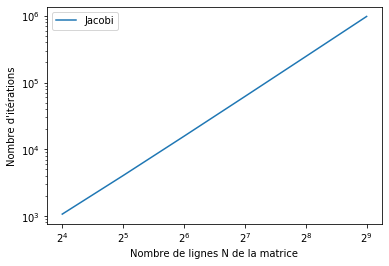

In [9]:
fig, ax = plt.subplots(1, 1)

ax.loglog(
    N, jacobi_iter,
    label="Jacobi"
)

ax.legend()

ax.set_xlabel("Nombre de lignes N de la matrice")
ax.set_xscale('log', basex=2)

ax.set_ylabel("Nombre d'itérations")

Si tout fonctionne correctement, vous devriez voir une droite sur cet graphique en échelle log-log.
Mathématiquement, cela indique que le nombre d'itérations est proportionel à $N^{\alpha}$.

**Question :** Essayez d'estimer la valeur de $\alpha$ pour la méthode de Jacobi.

### La méthode de Gauss-Seidel

La seconde méthode à laquelle nous allons nous intéresser est celle de *Gauss-Seidel*, nommée ainsi après les mathématiciens allemands Carl Friedrich Gauss (1777-1855) et Philipp Ludwig von Seidel (1821-1896).
La méthode de Gauss-Seidel diffère de celle de Jacobi en ce sens que la matrice $\mathbf{A}$ est maintenant décomposée de la façon suivante

$$
\mathbf{A} = \mathbf{L} + \mathbf{R}
$$

où $\mathbf{L}$ est la partie triangulaire inférieure de $\mathbf{A}$ et $\mathbf{R}$ le reste.

---

**Exemple :** Reprenons l'exemple précédent, à savoir

$$
\mathbf{A}
=
\begin{bmatrix}
    2 & -1 & 0 & 0 \\
    -1 & 2 & -1 & 0 \\
    0 & -1 & 2 & -1 \\
    0 & 0 & -1 & 2
\end{bmatrix}.
$$

Dans ce cas, la matrice $\mathbf{L}$ est donnée par


$$
\mathbf{L}
=
\begin{bmatrix}
    2 & 0 & 0 & 0 \\
    -1 & 2 & 0 & 0 \\
    0 & -1 & 2 & 0 \\
    0 & 0 & -1 & 2
\end{bmatrix},
$$

tandis que la matrice $\mathbf{R}$ est égale à


$$
\mathbf{R}
=
\begin{bmatrix}
    0 & -1 & 0 & 0 \\
    0 & 0 & -1 & 0 \\
    0 & 0 & 0 & -1 \\
    0 & 0 & 0 & 0
\end{bmatrix}.
$$

---

En utilisant cette décomposition, on peut montrer que la solution de notre système linéaire peut être approximée de façon sucessive par l'itération suivante

$$
\mathbf{x}_{k+1} = \mathbf{L}^{-1} \left( \mathbf{b} - \mathbf{Rx}_k \right).
$$

Comme précédemment, cette itération peut être ré-écrite sous la forme

$$
\mathbf{x}_{k+1} = \mathbf{x}_k + \mathbf{L}^{-1}\left( \mathbf{b} - \mathbf{Ax}_k \right).
$$

Contrairement à la méthode de Jacobi où l'on doit inverser une matrice diagonale (quelque chose de très simple à faire), la méthode de Gauss-Seidel nécessite d'inverser une matrice triangulaire inférieure.
Il est important de noter malgré tout que cela peut se faire aisément à l'aide d'algorithmes dédiés (voir par exemple [Wikipedia](https://en.wikipedia.org/wiki/Triangular_matrix)).
Afin de résoudre ce problème linéaire à chaque itération de la méthode de Gauss-Seidel, vous allez avoir à utiliser la fonction `solve_triangular`.
Pour un système du type $\mathbf{Lx} = \mathbf{y}$ avec $\mathbf{L}$ triangulaire inférieure, la solution est obtenue en faisant

```
x = solve_triangular(L, y)
```

Par ailleurs, la partie triangulaire inférieure de la matrice $\mathbf{A}$ est obtenue en faisant

```
L = np.tril(A, k=0)
```

C'est maintenant à vous de jouer et d'implémenter la méthode de Gauss-Seidel.
La fonction ci-dessous vous fournit le squelette à utiliser.

In [10]:
def gauss_seidel_solve(A, b, tol=1e-8, maxiter=10**8):
    """
    Cette fonction implémente la méthode de Gauss-Seidel pour résoudre le système linéaire Ax=b
    de façon itérative.
    
    INPUTS
    ------
    
    A : numpy array, shape (n, n).
        Matrice A déterminant le système linéaire à résoudre.
    
    b : numpy array, shape (n,).
        Terme de droite du système à résoudre
        
    tol : float (default = 1e-8)
          Tolérance pour la résolution du système.
          
    maxiter : int (default = 10**8)
              Nombre maximum d'itérations autorisées.
              
    RETURNS
    -------
    
    x : numpy array, shape (n,).
        Solution du système linéaire.
        
    iteration : int
                Nombre d'itérations faites.
        
    residual : numpy array, shape (k,).
               Historique de l'évolution du résidu normalisé || b - Ax || / || b ||.
    """
    
    ############################################
    #####     INITIALISATIONS DIVERSES     #####
    ############################################
    
    # --> Extrait et inverse la diagonale de la matrice A.
    L = np.tril(A, k=0)
    
    # --> Vecteur solution.
    x = np.zeros_like(b)
    
    # --> Historique du résidu.
    residual = [normalized_residual(A, x, b)]
    
    ###########################################
    #####     METHODE DE GAUSS-SEIDEL     #####
    ###########################################
    
    for iteration in range(maxiter):
        
        # --> Mise à jour de la solution.
        x += solve_triangular(L, b - A @ x)
        
        # --> Calcul du résidu.
        residual.append(normalized_residual(A, x, b))
        
        # --> On sort de la boucle si le résidu est inférieur à la tolérance souhaitée.
        if residual[-1] < tol:
            break
    
    return x, iteration, np.asarray(residual)

#### Validation sur un cas test

Avant de s'intéresser aux performances de la méthode de Gauss-Seidel en fonction de la taille de la matrice, vérifions que notre implémentation fonctionne correctement en utilisant un cas test simple que l'on peut résoudre à la main.
Pour cela, on utilise le même problème que tout à l'heure, à savoir

$$
\begin{bmatrix}
-2 & 1 \\
1 & -2
\end{bmatrix}
\begin{bmatrix}
x \\
y
\end{bmatrix}
=
\begin{bmatrix}
1 \\
1
\end{bmatrix}.
$$

In [11]:
# --> Définition de la matrice A et du vecteur b.
A = np.array([[-2.0, 1.0], [1.0, -2.0]])
b = np.array([1.0, 1.0])

# --> Résolution du système linéaire par la méthode de Gauss-Seidel.
x, iteration, residual = gauss_seidel_solve(A, b)

# -->
print("La méthode de Gauss-Seidel a convergé en {0} itérations.".format(iteration))

La méthode de Gauss-Seidel a convergé en 13 itérations.


In [12]:
# --> Vérification que la solution numérique est proche de celle analytique.
if np.allclose(x, np.array([-1, -1])):
    print("La solution numérique est en accord avec celle analytique.")
else:
    print("La solution numérique est différente de celle analytique.")

La solution numérique est en accord avec celle analytique.


Une fois que votre solution numérique est en accord avec celle analytique, vous pouvez passer à la suite du TP.

#### Nombre d'itérations vs taille de la matrice

Revenons maintenant à notre vrai problème et regardons comment se comporte la méthode de Gauss-Seidel.
Nous pouvons utiliser la même fonction `scaling_analysis` que tout à l'heure.

In [13]:
# --> Performances de la méthode de Gauss-Seidel
#     pour des problèmes de taille croissante.
N, gs_iter = scaling_analysis(gauss_seidel_solve)

100%|██████████| 6/6 [02:15<00:00, 22.53s/it]


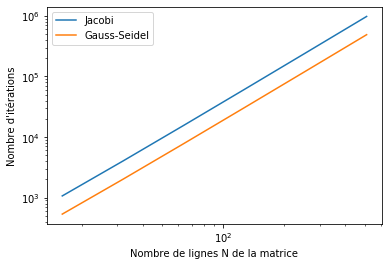

In [14]:
ax.loglog(
    N, gs_iter,
    label="Gauss-Seidel"
)

ax.legend()

fig

Si tout fonctionne correctement, vous devriez voir encore une fois une droite sur ce graphique en échelle log-log.
Mathématiquement, cela indique que le nombre d'itérations est proportionel à $N^{\alpha}$.
Bien que l'exposant $\alpha$ soit le même pour les deux méthodes, vous devriez voir que la méthode de Gauss-Seidel nécessite deux fois moins d'itérations pour converger comparée à la méthode de Jacobi.


### La méthode SOR

La dernière méthode que nous allons voir est celle des *sur-relaxations sucessives*, ou *successive over-relaxation* (SOR) en anglais.
Il s'agit d'une modification relativement simple de la méthode de Gauss-Seidel permettant d'accélérer grandement la vitesse de convergence.
Pour cela, la matrice $\mathbf{A}$ est décomposé de la façon suivante

$$
\mathbf{A} = \mathbf{L}_* + \mathbf{D} + \mathbf{R}
$$

où $\mathbf{L}_*$ est la partie triangulaire strictement inférieure de $\mathbf{A}$.


---

**Exemple :** Reprenons l'exemple précédent, à savoir

$$
\mathbf{A}
=
\begin{bmatrix}
    2 & -1 & 0 & 0 \\
    -1 & 2 & -1 & 0 \\
    0 & -1 & 2 & -1 \\
    0 & 0 & -1 & 2
\end{bmatrix}.
$$

Dans ce cas, la matrice $\mathbf{L}_*$ est donnée par


$$
\mathbf{L}_*
=
\begin{bmatrix}
    0 & 0 & 0 & 0 \\
    -1 & 0 & 0 & 0 \\
    0 & -1 & 0 & 0 \\
    0 & 0 & -1 & 0
\end{bmatrix}.
$$

---

Notre itération est ensuite donnée par

$$
\mathbf{x}_{k+1} = \left( \mathbf{L}_* + \frac{\mathbf{D}}{\omega} \right)^{-1} \left( \mathbf{b} - \mathbf{Rx}_k \right).
$$

Encore une fois, on peut ré-écrire cette itération sous la forme

$$
\mathbf{x}_{k+1} = \mathbf{x}_k + \left( \mathbf{L}_* + \frac{\mathbf{D}}{\omega} \right)^{-1} \left( \mathbf{b} - \mathbf{Ax}_k \right).
$$

Il est alors évident que la méthode SOR avec pour $\omega = 1$ est identique à la méthode de Gauss-Seidel.
C'est maintenant à vous de jouer.

In [15]:
def sor_solve(A, b, omega=1.9, tol=1e-8, maxiter=10**8):
    """
    Cette fonction implémente la méthode SOR pour résoudre le système linéaire Ax=b
    de façon itérative.
    
    INPUTS
    ------
    
    A : numpy array, shape (n, n).
        Matrice A déterminant le système linéaire à résoudre.
    
    b : numpy array, shape (n,).
        Terme de droite du système à résoudre
        
    tol : float (default = 1e-8)
          Tolérance pour la résolution du système.
          
    maxiter : int (default = 10**8)
              Nombre maximum d'itérations autorisées.
              
    omega : float (default = 1.9)
            Paramètre de sur-relaxation.
              
    RETURNS
    -------
    
    x : numpy array, shape (n,).
        Solution du système linéaire.
        
    iteration : int
                Nombre d'itérations faites.
        
    residual : numpy array, shape (k,).
               Historique de l'évolution du résidu normalisé || b - Ax || / || b ||.
    """
    
    ############################################
    #####     INITIALISATIONS DIVERSES     #####
    ############################################
    
    # --> Extrait et inverse la diagonale de la matrice A.
    L = np.tril(A, k=-1)
    D = np.diag(A.diagonal() / omega)
    P = D + L
    
    # --> Vecteur solution.
    x = np.zeros_like(b)
    
    # --> Historique du résidu.
    residual = [normalized_residual(A, x, b)]
    
    ###############################
    #####     METHODE SOR     #####
    ###############################
    
    for iteration in range(maxiter):
        
        # --> Mise à jour de la solution.
        x += solve_triangular(P, b - A @ x)
        
        # --> Calcul du résidu.
        residual.append(normalized_residual(A, x, b))
        
        # --> On sort de la boucle si le résidu est inférieur à la tolérance souhaitée.
        if residual[-1] < tol:
            break
            
    return x, iteration, np.asarray(residual)

#### Validation sur un cas test

Avant de s'intéresser aux performances de la méthode SOR en fonction de la taille de la matrice, vérifions que notre implémentation fonctionne correctement en utilisant un cas test simple que l'on peut résoudre à la main.
Pour cela, on utilise le même problème que tout à l'heure, à savoir

$$
\begin{bmatrix}
-2 & 1 \\
1 & -2
\end{bmatrix}
\begin{bmatrix}
x \\
y
\end{bmatrix}
=
\begin{bmatrix}
1 \\
1
\end{bmatrix}.
$$

In [16]:
# --> Définition de la matrice A et du vecteur b.
A = np.array([[-2.0, 1.0], [1.0, -2.0]])
b = np.array([1.0, 1.0])

# --> Résolution du système linéaire par la méthode SOR.
x, iteration, residual = sor_solve(A, b, omega=1.1)

# -->
print("La méthode SOR a convergé en {0} itérations.".format(iteration))

La méthode SOR a convergé en 8 itérations.


In [17]:
# --> Vérification que la solution numérique est proche de celle analytique.
if np.allclose(x, np.array([-1, -1])):
    print("La solution numérique est en accord avec celle analytique.")
else:
    print("La solution numérique est différente de celle analytique.")

La solution numérique est en accord avec celle analytique.


Une fois que votre solution numérique est en accord avec celle analytique, vous pouvez passer à la suite du TP.

#### Nombre d'itérations vs taille de la matrice

Revenons maintenant à notre vrai problème et regardons comment se comporte la méthode SOR.
Nous pouvons utiliser la même fonction `scaling_analysis` que tout à l'heure.

In [18]:
# --> Performances de la méthode SOR pour des problèmes de taille croissante.
N, sor_iter = scaling_analysis(sor_solve)

100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


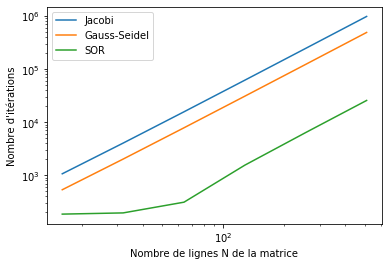

In [19]:
ax.loglog(
    N, sor_iter,
    label="SOR"
)

ax.legend()

fig

Si tout fonctionne correctement, vous devriez voir encore une fois une droite (pour $N$ suffisament grand) sur ce graphique en échelle log-log.
Mathématiquement, cela indique que le nombre d'itérations est proportionel à $N^{\alpha}$.
Bien que l'exposant $\alpha$ soit le même pour les trois méthodes, vous devriez voir que la méthode SOR converge plus rapidement (jusqu'à 100 fois plus rapidement) que la méthode de Gauss-Seidel.
Parce qu'elle est relativement performante et simple à mettre en place, la méthode SOR fait donc partie des méthodes de résolution de systèmes linéaires parmis les plus fréquemment utilisées en calcul scientifique.